In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [2]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results, load_single_result
from io_utils import save_data_to_file
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(res_dir, 'entero_data', 'results', '{}_{}'.format(method, mtype))
os.makedirs(ddir, exist_ok=True)
fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}
ddir

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


'/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/graph_vanilla'

In [3]:
from io_utils import load_data_from_file
from intestine_info import load_gene_set_clusters
result = load_single_result(RDIR, method, mtype)
# save_data_to_file(result, fns['result'], 'pkl')
n_rej = len(result['rejections'])
n_genes = len(result['p_vals'])
print('Number of rejections: {} ({:.2f}%)'.format(n_rej, n_rej / n_genes * 100))
c_mtx = load_data_from_file(fns['coeff_mtx'], 'npy')
kmtx, kdf = load_gene_set_clusters(var_df)
embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
clust = np.ones(var_df.shape[0]) * -1
clust[kdf['orig_idx']] = kdf['clust_idx']
var_df['moor_clust'] = clust

Number of rejections: 6892 (71.38%)


In [4]:
var_df.head()

,gene_ids,n_cells,mean,std,npc,moor_clust
0,Mrpl15,530,0.386412,0.530710,530,1.0
1,Lypla1,1045,0.999767,0.698513,1045,3.0
2,Tcea1,367,0.225788,0.401705,367,-1.0
3,Atp6v1h,171,0.101006,0.292252,171,-1.0
4,Rb1cc1,340,0.220587,0.425791,340,-1.0


In [5]:
kdf.head()

,indin,clust_idx,curr_idx,orig_idx
gene_name,,,,
Mrpl15,8,1,0,0
Lypla1,9,3,1,1
Arfgef1,40,3,2,14
Tram1,52,1,3,16
Rpl7,63,4,4,20


In [6]:
df = embed_dict["rejected_coefficient"]
df.head()

,umap 1,umap 2,id
0,1.157305,5.610837,0
1,-5.631617,4.360916,1
2,6.405178,0.131172,2
3,9.547291,-1.789158,7
4,8.179799,-0.237670,11


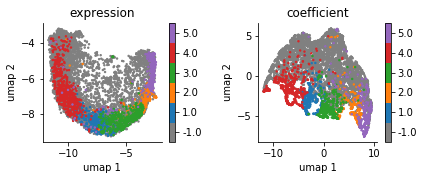

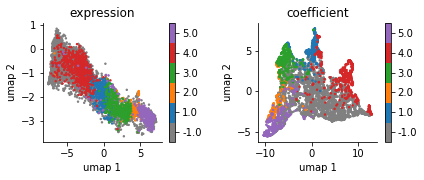

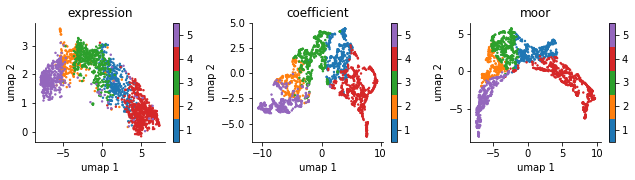

In [7]:
from plot_utils import plot_scatter_discrete, get_sim_color_map
sel_list = ['all', 'rejected', 'trim']
for j, sel in enumerate(sel_list):
    if sel == 'trim':
        methods = ['expression', 'coefficient', 'moor']
    else:
        methods = ['expression', 'coefficient']
    fig, axes = plt.subplots(1, len(methods), figsize=(3*len(methods),2.6))    
    for i, met in enumerate(methods):
        df = embed_dict["{}_{}".format(sel, met)]
        ax = axes[i]
        if sel == 'trim':
            df['labs'] = kdf['clust_idx'].values
        else:
            df['labs'] = var_df.loc[df['id']]['moor_clust'].values
        lut = get_sim_color_map(df['labs'], palette='tab10')
        df = df.sort_values(by='labs')
        plot_scatter_discrete(df[["umap 1", "umap 2"]].values, 
                              df['labs'], cols=lut,
                              ax=ax, ms=2)
        ax.set_title(met)
        ax.set_xlabel('umap 1')
        ax.set_ylabel('umap 2')
    plt.tight_layout()
    plt.show()

In [8]:
# our pipeline
import umap
uobj = umap.UMAP(random_state=10101)
sel_idx = result["rejections"]
u_mtx = c_mtx[sel_idx, :]
print("input dimension: {}".format(u_mtx.shape))
embedding = uobj.fit_transform(u_mtx)

input dimension: (6892, 5)


In [14]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

A = graph
n_eigs = 10
L = csgraph.laplacian(A)
eigenvalues, eigenvectors = eigsh(L, which='SM', k=n_eigs)

In [15]:
from sklearn.cluster import KMeans

X = eigenvectors[:, 1:]
df = pd.DataFrame()
for n_clust in [4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
    labs = kmeans.labels_
    name = 'k_{}'.format(n_clust)
    df[name] = labs
    print(name)

k_4
k_5
k_6
k_7
k_8


(1913, 4)


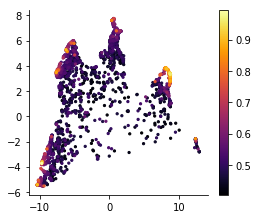

In [51]:
from plot_utils import plot_scatter_continuous
emb = embed_dict["rejected_coefficient"][['umap 1', 'umap 2']].copy()
emb['std'] = var_df.loc[sel_idx]['std'].values
emb['mean'] = var_df.loc[sel_idx]['mean'].values
ddf = emb.loc[emb['std'] > 0.5]
print(ddf.shape)
fig, ax = plt.subplots(1,1,figsize=(4, 3.4))
plot_scatter_continuous(ddf[['umap 1', 'umap 2']], ddf['std'], ax=ax)
plt.show()

In [26]:
embed_dict.keys()

dict_keys(['all_coefficient', 'all_expression', 'rejected_coefficient', 'rejected_expression', 'trim_expression', 'trim_moor', 'trim_coefficient'])

In [23]:
emb.head()

,umap 1,umap 2,id,labs
0,1.157305,5.610837,0,1.0
1,-5.631617,4.360916,1,3.0
2,6.405178,0.131172,2,-1.0
3,9.547291,-1.789158,7,-1.0
4,8.179799,-0.237670,11,-1.0


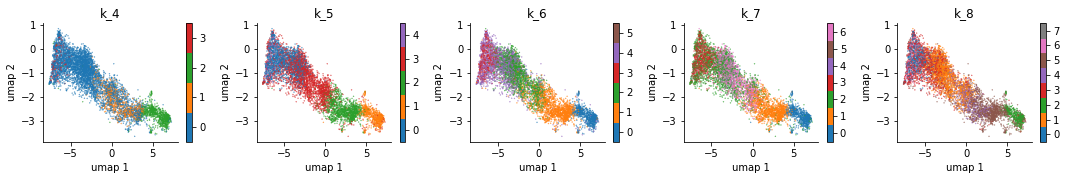

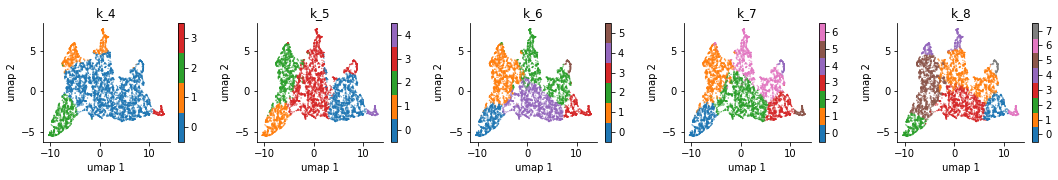

In [18]:
from plot_utils import plot_scatter_discrete, get_sim_color_map
sel_list = ['all', 'rejected']
methods = df.columns
for dat in ['expression', 'coefficient']:
    fig, axes = plt.subplots(1, len(methods), figsize=(3*len(methods),2.6))    
    for i, met in enumerate(methods):
        embedding = embed_dict["{}_{}".format('rejected', dat)]
        ax = axes[i]
        lut = get_sim_color_map(df[met], palette='tab10')
        plot_scatter_discrete(embedding, 
                              df[met], cols=lut,
                              ax=ax, ms=0.1)
        ax.set_title(met)
        ax.set_xlabel('umap 1')
        ax.set_ylabel('umap 2')
    plt.tight_layout()
    plt.show()

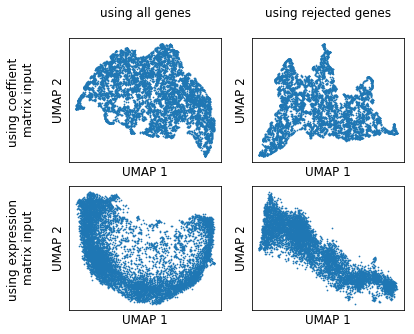

In [6]:
# plot the embeddings
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        x = plt_df['umap 1']
        y = plt_df['umap 2']
        ax.scatter(x, y, s=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.show()

In [ ]:
# comparison with the kmeans clustering in the original paper
dat_dir = "/share/PI/sabatti/sc_data/intestine2k"
fn =  os.path.join(dat_dir, "extracted", "kmeans_meta.csv")
kdf = pd.read_csv(fn)
fn =  os.path.join(dat_dir, "extracted", "kmeans_data.csv")
kmtx = pd.read_csv(fn, header=None).values

In [ ]:
kdf['curr_idx'] = kdf.index
kdf = kdf.set_index('gene_name')
gdf = var_df[['gene_ids']].copy()
gdf['orig_idx'] = gdf.index
gdf = gdf.set_index('gene_ids')
kdf['orig_idx'] = gdf.loc[kdf.index]['orig_idx']
kdf.head()

In [ ]:
from main_methods import compute_embedding
moor = compute_embedding(kmtx)
ours = compute_embedding(c_mtx[kdf['orig_idx'], :])

In [ ]:
from general_utils import norm_mtx
mm = norm_mtx(mtx[:, kdf['orig_idx']])
naive = compute_embedding(mm.T)
naive['umap 1'] = -naive['umap 1']

In [ ]:
short_embed = {'naive': naive, 'moor': moor,  'ours': ours}

In [ ]:
from plot_utils import plot_scatter_discrete
var_labs = kdf['clust_idx']
fig, axes = plt.subplots(1, len(short_embed), figsize=(3.2*len(short_embed),2.5))
for i, m in enumerate(short_embed.keys()):
    df = short_embed[m]
    ax = axes[i]
    plot_scatter_discrete(df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=2)
    ax.set_title(m)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.show()

input dimension: (2118, 5)


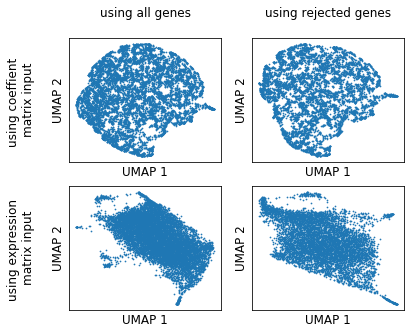

In [17]:
# plot the embeddings
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        x = plt_df['umap 1']
        y = plt_df['umap 2']
        ax.scatter(x, y, s=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.show()